In [1]:
import sys
import os

sys.path.append(os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt
from modules.extraction.embedding import EmbeddingExtractor
from modules.retrieval.index import Indexer
from modules.retrieval.search import Searcher
from pipeline import Pipeline
import torch
from PIL import Image
from facenet_pytorch import InceptionResnetV1
import faiss
import numpy as np
from torchvision import transforms
from scipy.spatial.distance import cosine
import random

In [2]:
pipeline_vggface = Pipeline(model='vggface2', device='cpu') 
pipeline_casia = Pipeline(model='casia-webface', device='cpu')

probe_directory = '../datasets/multi_image_identities/probe'
gallery_directory = '../datasets/multi_image_identities/multi_image_gallery'

In [3]:
pipeline_vggface.precompute(gallery_directory)
pipeline_vggface.save_embeddings('../storage/catalog/faiss_vggface.bin')

pipeline_casia.precompute(gallery_directory)
pipeline_casia.save_embeddings('../storage/catalog/faiss_casia.bin')

Number of embeddings to add: 2265
Number of embeddings added to FAISS: 2265
Number of gallery filenames: 2265
Number of embeddings to add: 2265
Number of embeddings added to FAISS: 2265
Number of gallery filenames: 2265


In [4]:
# Dictionaries to store the results
vggface_results = {}
casia_results = {}

# Traverse the probe directory to get all probe images
for root, dirs, files in os.walk(probe_directory):
    for filename in files:
        if filename.endswith(('.jpg', '.png')):
            image_path = os.path.join(root, filename)
            image = Image.open(image_path)

            # Encode the image into an embedding
            probe_embedding_vggface = pipeline_vggface.encode(image)
            probe_embedding_casia = pipeline_casia.encode(image)

            # Perform FAISS search using the embeddings
            neighbors_vggface = pipeline_vggface.search_gallery(probe_embedding_vggface, k=5)
            neighbors_casia = pipeline_casia.search_gallery(probe_embedding_casia, k=5)

            # Store the results
            vggface_results[filename] = neighbors_vggface
            casia_results[filename] = neighbors_casia

# Print example results
print("VGGFace Results for Probe Images:", vggface_results)
print("Casia-Webface Results for Probe Images:", casia_results)

VGGFace Results for Probe Images: {'Paul_McNulty_0002.jpg': [(('Paul_McNulty', 'Paul_McNulty_0001.jpg'), 0.41251633), (('Sean_Astin', 'Sean_Astin_0002.jpg'), 0.7705041), (('Mike_Babcock', 'Mike_Babcock_0001.jpg'), 0.8171375), (('Bill_Frist', 'Bill_Frist_0006.jpg'), 0.9046857), (('Ann_Veneman', 'Ann_Veneman_0009.jpg'), 0.9184737)], 'Mary-Kate_Olsen_0002.jpg': [(('Mary-Kate_Olsen', 'Mary-Kate_Olsen_0001.jpg'), 0.42585242), (('Mary-Kate_Olsen', 'Mary-Kate_Olsen_0002.jpg'), 0.65783614), (('Evan_Rachel_Wood', 'Evan_Rachel_Wood_0001.jpg'), 0.78179204), (('Sarah_Jessica_Parker', 'Sarah_Jessica_Parker_0003.jpg'), 0.80074483), (('Mary_Landrieu', 'Mary_Landrieu_0002.jpg'), 0.8268363)], 'Phil_Mickelson_0002.jpg': [(('Phil_Mickelson', 'Phil_Mickelson_0001.jpg'), 0.46805406), (('Yevgeny_Kafelnikov', 'Yevgeny_Kafelnikov_0001.jpg'), 0.7576541), (('Jim_Furyk', 'Jim_Furyk_0004.jpg'), 0.77930224), (('Fred_Funk', 'Fred_Funk_0001.jpg'), 0.81262153), (('Larry_Coker', 'Larry_Coker_0002.jpg'), 0.8312421)], '

In [5]:
def add_noise(image, noise_level=0.1):
    if not isinstance(image, torch.Tensor):
        raise ValueError("Image must be a preprocessed tensor.")
    
    # Generate random noise
    noise = torch.randn_like(image) * noise_level
    noisy_image = image + noise
    return torch.clamp(noisy_image, -1, 1)

In [6]:
preprocess = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


In [7]:
noisy_vggface_results = {}
noisy_casia_results = {}

# Traverse the probe directory again to apply noise to each image
for root, dirs, files in os.walk(probe_directory):
    for filename in files:
        if filename.endswith(('.jpg', '.png')):
            image_path = os.path.join(root, filename)
            image = Image.open(image_path)

            # Preprocess the image into a tensor
            image_tensor = preprocess(image)

            # Add noise to the image tensor
            noisy_image = add_noise(image_tensor)

            # Encode the noisy image into an embedding
            noisy_embedding_vggface = pipeline_vggface.encode(noisy_image)
            noisy_embedding_casia = pipeline_casia.encode(noisy_image)

            # Perform FAISS search using the noisy embeddings
            noisy_neighbors_vggface = pipeline_vggface.search_gallery(noisy_embedding_vggface, k=5)
            noisy_neighbors_casia = pipeline_casia.search_gallery(noisy_embedding_casia, k=5)

            # Store the noisy results
            noisy_vggface_results[filename] = noisy_neighbors_vggface
            noisy_casia_results[filename] = noisy_neighbors_casia

# Print example noisy results
print("Noisy VGGFace Results for Probe Images:", noisy_vggface_results)
print("Noisy Casia-Webface Results for Probe Images:", noisy_casia_results)


Noisy VGGFace Results for Probe Images: {'Paul_McNulty_0002.jpg': [(('Paul_McNulty', 'Paul_McNulty_0001.jpg'), 0.3782478), (('Mike_Babcock', 'Mike_Babcock_0001.jpg'), 0.6845701), (('Sean_Astin', 'Sean_Astin_0002.jpg'), 0.77630013), (('Kenneth_Branagh', 'Kenneth_Branagh_0001.jpg'), 0.80241585), (('Bill_Frist', 'Bill_Frist_0006.jpg'), 0.8232345)], 'Mary-Kate_Olsen_0002.jpg': [(('Mary-Kate_Olsen', 'Mary-Kate_Olsen_0001.jpg'), 0.5348383), (('Evan_Rachel_Wood', 'Evan_Rachel_Wood_0001.jpg'), 0.70688534), (('Mary-Kate_Olsen', 'Mary-Kate_Olsen_0002.jpg'), 0.7609564), (('Blythe_Danner', 'Blythe_Danner_0001.jpg'), 0.8576733), (('Mary_Landrieu', 'Mary_Landrieu_0002.jpg'), 0.90930367)], 'Phil_Mickelson_0002.jpg': [(('Phil_Mickelson', 'Phil_Mickelson_0001.jpg'), 0.5269841), (('Yevgeny_Kafelnikov', 'Yevgeny_Kafelnikov_0001.jpg'), 0.76048934), (('Fred_Funk', 'Fred_Funk_0001.jpg'), 0.81697786), (('Jim_Furyk', 'Jim_Furyk_0004.jpg'), 0.8582533), (('Larry_Coker', 'Larry_Coker_0002.jpg'), 0.86154306)], 'J

In [8]:
def calculate_average_distance(results):
    avg_distances = {}
    for filename, neighbors in results.items():
        distances = [neighbor[1] for neighbor in neighbors]
        avg_distances[filename] = np.mean(distances)
    return avg_distances


In [9]:
vggface_avg_distances = calculate_average_distance(vggface_results)
casia_avg_distances = calculate_average_distance(casia_results)

noisy_vggface_avg_distances = calculate_average_distance(noisy_vggface_results)
noisy_casia_avg_distances = calculate_average_distance(noisy_casia_results)


In [10]:
filenames = list(vggface_avg_distances.keys())
vggface_distances = list(vggface_avg_distances.values())
casia_distances = list(casia_avg_distances.values())
noisy_vggface_distances = list(noisy_vggface_avg_distances.values())
noisy_casia_distances = list(noisy_casia_avg_distances.values())

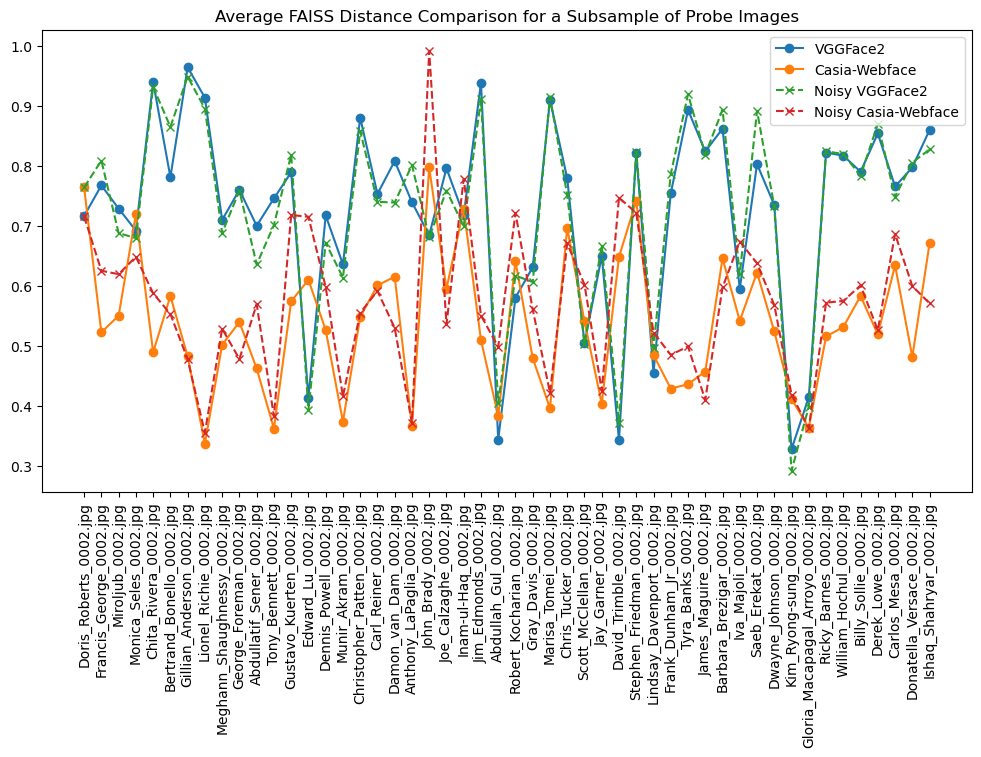

In [11]:
sample_filenames = random.sample(filenames, 50)
vggface_sample = [vggface_avg_distances[f] for f in sample_filenames]
casia_sample = [casia_avg_distances[f] for f in sample_filenames]
noisy_vggface_sample = [noisy_vggface_avg_distances[f] for f in sample_filenames]
noisy_casia_sample = [noisy_casia_avg_distances[f] for f in sample_filenames]

plt.figure(figsize=(12, 6))
plt.plot(sample_filenames, vggface_sample, label='VGGFace2', marker='o')
plt.plot(sample_filenames, casia_sample, label='Casia-Webface', marker='o')
plt.plot(sample_filenames, noisy_vggface_sample, label='Noisy VGGFace2', linestyle='--', marker='x')
plt.plot(sample_filenames, noisy_casia_sample, label='Noisy Casia-Webface', linestyle='--', marker='x')
plt.xticks(rotation=90)
plt.legend()
plt.title('Average FAISS Distance Comparison for a Subsample of Probe Images')
plt.show()

1. General Prediction Model Performance
Looking at the plot, the performance of the two models, VGGFace2 and Casia-Webface, shows some distinct patterns:

VGGFace2 (blue line) tends to have higher FAISS distances on average, indicating that its embeddings may be less tightly clustered in the gallery compared to Casia-Webface. However, VGGFace2 appears more consistent across probe images.
Casia-Webface (orange line) has lower FAISS distances on average, meaning its embeddings are generally closer to their nearest neighbors. This suggests that Casia-Webface might create embeddings that are more tightly packed or more easily distinguishable within the gallery.
Both models have instances where the distances spike, showing that for some images, the models struggle to find close matches, but Casia-Webface seems to perform slightly better in terms of tighter clusters.

2. Performance Impact of Noise Transformations
The effect of noise transformations is clearly visible:

Noisy VGGFace2 (green dashed line) shows a significant increase in FAISS distances compared to the non-noisy version, indicating that VGGFace2 is relatively sensitive to noise. There are more extreme fluctuations, and the distances are consistently higher.
Noisy Casia-Webface (red dashed line) also shows increased FAISS distances, but its performance is less affected compared to VGGFace2. The noisy Casia-Webface embeddings remain closer to the original non-noisy results, implying better noise robustness.
Key takeaway: Both models experience performance degradation when noise is introduced, but Casia-Webface seems to be more resilient, showing less severe distance increases compared to VGGFace2.

3. Impact on System Design
Based on the observations, here are some key takeaways for system design:

Model Selection: Since Casia-Webface shows tighter clusters and is more resilient to noise, it might be a better choice for situations where noise or imperfect conditions are expected (e.g., real-world applications where probe images might not always be clean).

Noise Handling: The significant impact of noise on both models suggests that some kind of noise reduction or preprocessing might be necessary before generating embeddings. For example, applying denoising algorithms or transformations before passing the images to the models could improve performance under noisy conditions.

FAISS Search Parameters: The larger FAISS distances in VGGFace2 embeddings could lead to more false positives or errors in retrieval. For such a system, adjusting FAISS search parameters (like increasing the number of nearest neighbors k) might improve robustness, or filtering results based on distance thresholds could help mitigate the impact.

Application Scenarios: If the system is intended for environments where the input images will be relatively clean (e.g., controlled conditions), VGGFace2 might still be suitable. However, if you expect the input images to have noise (e.g., from low-quality cameras or varying conditions), Casia-Webface would likely offer better performance.

Conclusion:
Casia-Webface provides generally better performance due to tighter clustering and better noise resilience.
VGGFace2 may still be useful in clean, controlled environments, but it’s more affected by noise.
For a robust system, denoising or preprocessing techniques and appropriate search thresholds will be crucial to handle noisy or degraded input images effectively.